# Evidence of Scaling Advantage for the QAOA Algorithm on a Classically Intractable Problem

This notebook solve the Low Autocorrlation Binary Sequences (LABS) problem using QAOA. It follows the paper from Shaydulin et al.[[1](#QAOA_LABS)].

Later, the paper accepted to the [Science Advances journal](https://www.science.org/doi/10.1126/sciadv.adm6761).

The LABS problem is relevant in various fields, including communications engineering, design of radar pulses, and more, where sequences with low autocorrelation properties are desired. The LABS problem is known to be NP-hard.

The LABS problem is defined as follows:

For a given sequence of spins $s_{i} \in \{-1,+1\}$, we have the autocorrelation $A_{k}(s)$.

First, define $A_{k}(s)$, the autocorrelation:

$$
A_{k}(s) = \sum_{i=1}^{N-k} s_{i}s_{i+k}
$$

The goal of LABS is to find a sequence of spins $s$ that minimizes the so-called "sidelobe" energy:

$$
E_{sidelobe} = \sum_{k=1}^{N-1} A_{k}^{2}(s)
$$


In [1]:
import numpy as np
import pyomo.core as pyo


def LABS_pyo_model(N: int) -> pyo.ConcreteModel:
    # N - the binary sequence size - number of spins
    # return: pyomo classical optimization model of
    # Low Binary Autocorrelation Binary Sequence (LABS) problem.
    model = pyo.ConcreteModel()

    model.s = pyo.Var(range(N), domain=pyo.Binary)

    s_array = np.array(list(model.s.values()))
    # transformation: {0,1} -> {-1,+1}
    spin_s_array = 2 * s_array - 1

    autocorrelation_fun = lambda k: sum(
        [
            spin_s_array[i] * spin_s_array[i + k]
            for i in range(len(spin_s_array[: N - k]))
        ]
    )

    model.sidelobe_energy = pyo.Objective(
        expr=sum([autocorrelation_fun(k) ** 2 for k in range(N - 1)]),
        sense=pyo.minimize,
    )
    return model

### Define the pyomo model

In [2]:
N = 13

labs_pyo_model = LABS_pyo_model(N)

### Define QAOA parameters
Define the number of layers, the number of iterations, optimizer, and more.
And define the number of spins, which is the number of qubits as well.

In [3]:
from classiq import *
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

N = 13

qaoa_config = QAOAConfig(num_layers=3, penalty_energy=0.0)

optimizer_config = OptimizerConfig(opt_type="COBYLA", max_iteration=60)

### Combine all the QAOA parameters to form a quantum model

In [4]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=labs_pyo_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

write_qmod(qmod, "labs_qaoa.qmod")

## Synthesize

In [5]:
qprog = synthesize(model=qmod, constraints=Constraints(optimization_parameter="cx"))
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/36pYxIFvXlrAXdIJ3RJ2i6uwwyZ


## Execute

In [6]:
from classiq import execute

res = execute(qprog).result()

## See results and convergence graph and result histogram

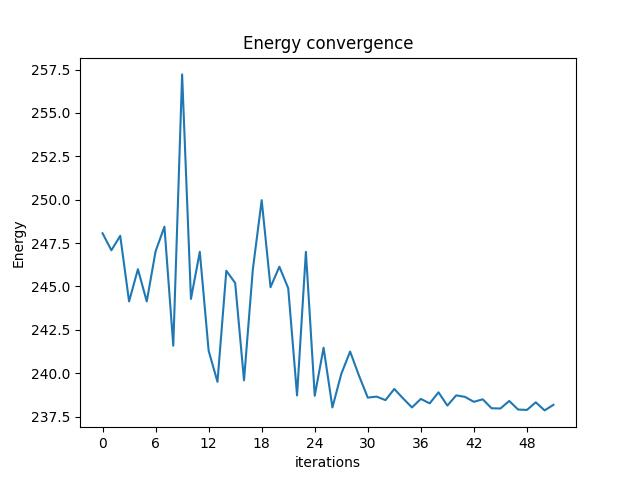

In [7]:
vqe_result = res[0].value
vqe_result.convergence_graph

In [8]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    labs_pyo_model, vqe_result=vqe_result, penalty_energy=qaoa_config.penalty_energy
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=True).head(5)

,probability,cost,solution,count
1320,0.000488,182.0,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]",1
1272,0.000488,182.0,"[1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0]",1
1193,0.000488,182.0,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]",1
1087,0.000488,186.0,"[1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]",1
1033,0.000488,186.0,"[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1]",1


array([[<Axes: title={'center': 'cost'}>]], dtype=object)

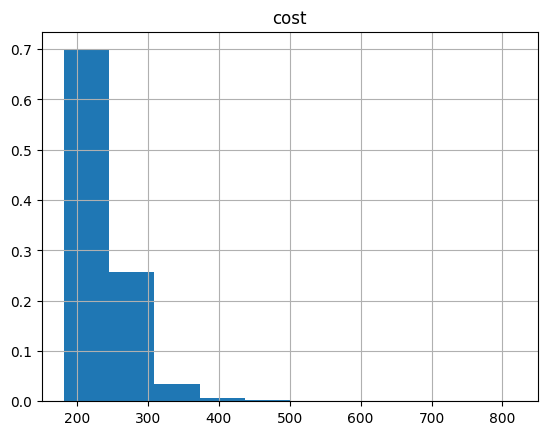

In [9]:
optimization_result.hist("cost", weights=optimization_result["probability"])

## References

<a name='QAOA_LABS'>[1]</a>: [Shaydulin, Ruslan, et al. "Evidence of scaling advantage for the quantum approximate optimization algorithm on a classically intractable problem." arXiv preprint arXiv:2308.02342 (2023).](https://arxiv.org/abs/2308.02342).